# IN3050/IN4050 Mandatory Assignment 3: Unsupervised Learning

**Name:** Dmitrii Soltaganov

**Username:** dmitriis@uio.no 

### Goals of the assignment
This assignment has two parts:
1. You will go through the basic theory of **Principal Component Analysis (PCA)** and implement PCA from scratch to compress and visualize data.
2. You will run **K-means clustering** using the `scikit-learn` toolkit and use PCA to visualize the results. You will also evaluate the output of K-means using a multi-class logistic regression classifier.

IN4050 students will have to do one extra part about tuning PCA to balance compression with information lost.

### Tools
You may freely use code from the weekly exercises and the published solutions. In the first part about PCA you may **NOT** use ML libraries like `scikit-learn`. In the K-means part and beyond we encourage the use of `scikit-learn` to iterate quickly on the problems.

We will use the *numpy* library for performing matrix computations and the *pyplot* library for plotting data, as well as *scikit-learn* for K-means clustering. This assignment also comes with a module called *data_assignment3* that you will use to import different (synthetic and real) datasets. Let's start by making sure that everything is installed.

In [86]:
%pip install numpy matplotlib scikit-learn

import data_assignment3


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


# Part 1: Principal Component Analysis (PCA)
In this section, you will work with the PCA algorithm in order to understand its definition and explore its uses.

## Part 1.1: Implementation
Here we implement the basic steps of PCA and we assemble them. We will only need functions from *numpy* for this part.

In [87]:
import numpy as np

### Centering the Data
Implement a function with the following signature to center the data. Remember that every *feature* should be centered.

In [88]:
def center_data(A):
    # INPUT:
    # A    [NxM] numpy data matrix (N samples, M features)
    #
    # OUTPUT:
    # X    [NxM] numpy centered data matrix (N samples, M features)
    center = A - np.mean(A, axis=0)

    return center

Test your function checking the following assertion on *testcase* (absence of output means that the assertion holds):

In [89]:
testcase = np.array([[3., 11., 4.3], [4., 5., 4.3], [5., 17., 4.5], [4, 13., 4.4]])
answer = np.array([[-1., -0.5, -0.075], [0., -6.5, -0.075], [1., 5.5, 0.125], [0., 1.5, 0.025]])
np.testing.assert_array_almost_equal(center_data(testcase), answer)

### Computing Covariance Matrix

Implement a function with the following signature to compute the covariance matrix. In order to get this at the correct scale, divide by $N - 1$, not $N$.

**Note:** Numpy provides a function `np.cov()` that does exactly this, but in this exercise we ask you to implement the code from scratch without using this function.

In [90]:
def compute_covariance_matrix(A):
    # INPUT:
    # A    [NxM] numpy data matrix (N samples, M features)
    #
    # OUTPUT:
    # C    [MxM] numpy covariance matrix (M features, M features)
     # Number of samples
    N = A.shape[0]
    
    # Compute mean of each feature (along columns)
    mean_vector = np.mean(A, axis=0)
    
    # Center the data by subtracting the mean
    A_centered = A - mean_vector
    
    # Compute covariance matrix (divide by N - 1)
    cov_matrix = (A_centered.T @ A_centered) / (N - 1)
    
    return cov_matrix

Test your function by comparing its output to the output of `np.cov()`:

In [91]:
test_array = np.array([[22.,11.,5.5],[10.,5.,2.5],[34.,17.,8.5],[28.,14.,7]])
answer = np.cov(np.transpose(test_array))
to_test = compute_covariance_matrix(test_array)
np.testing.assert_array_almost_equal(to_test, answer)

### Computing eigenvalues and eigenvectors
Use the linear algebra package of `numpy` and its function `np.linalg.eig()` to compute eigenvalues and eigenvectors. Note that we only take the real part of the eigenvectors and eigenvalues. The covariance matrix *should* be a symmetric matrix, but the actual implementation in `compute_covariance_matrix()` can lead to small round off errors that lead to tiny imaginary additions to the eigenvalues and eigenvectors. These are purely numerical artifacts that we can safely remove.

**Note:** If you decide to NOT use `np.linalg.eig()` you must make sure that the eigenvalues you compute are of unit length!

In [92]:
def compute_eigenvalue_eigenvectors(A):
    # INPUT:
    # A    [DxD] numpy matrix
    #
    # OUTPUT:
    # eigval    [D] numpy vector of eigenvalues
    # eigvec    [DxD] numpy array of eigenvectors
    
    eigval, eigvec = np.linalg.eig(A)
    
    # Numerical roundoff can lead to (tiny) imaginary parts. We correct that here.
    eigval = eigval.real
    eigvec = eigvec.real
    
    return eigval, eigvec

Test your function checking the following assertion on *testcase*:

In [93]:
testcase = np.array([[2, 0, 0], [0, 5, 0], [0, 0, 4]])
answer_eigval = np.array([2., 5., 4.])
answer_eigvec = np.array([[1., 0., 0.], [0., 1., 0.], [0., 0., 1.]])
x, y = compute_eigenvalue_eigenvectors(testcase)
np.testing.assert_array_almost_equal(x, answer_eigval)
np.testing.assert_array_almost_equal(y, answer_eigvec)

### Sorting eigenvalues and eigenvectors
Implement a function with the following signature to sort eigenvalues and eigenvectors in descending order.

Remember that eigenvalue `eigval[i]` corresponds to eigenvector `eigvec[:, i]`.

In [94]:
def sort_eigenvalue_eigenvectors(eigval, eigvec):
    # INPUT:
    # eigval    [D] numpy vector of eigenvalues
    # eigvec    [DxD] numpy array of eigenvectors
    #
    # OUTPUT:
    # sorted_eigval    [D] numpy vector of eigenvalues
    # sorted_eigvec    [DxD] numpy array of eigenvectors
    
    sorted_indices = np.argsort(eigval)[::-1]
    
    # Sort eigenvalues and eigenvectors using these indices
    sorted_eigval = eigval[sorted_indices]
    sorted_eigvec = eigvec[:, sorted_indices]
    
    return sorted_eigval, sorted_eigvec

Test your function checking the following assertion on *testcase*:

In [95]:
testcase = np.array([[2, 0, 0], [0, 5, 0], [0, 0, 4]])
answer_eigval = np.array([5., 4., 2.])
answer_eigvec = np.array([[0., 0., 1.], [1., 0., 0.], [0., 1., 0.]])
x, y = compute_eigenvalue_eigenvectors(testcase)
x, y = sort_eigenvalue_eigenvectors(x, y)
np.testing.assert_array_almost_equal(x, answer_eigval)
np.testing.assert_array_almost_equal(y, answer_eigvec)

### PCA Algorithm
Implement a function with the following signature to compute PCA using the functions implemented above.

In [96]:
def pca(A, m):
    # INPUT:
    # A    [NxM] numpy data matrix (N samples, M features)
    # m    integer number denoting the number of learned features (m <= M)
    #
    # OUTPUT:
    # pca_eigvec    [Mxm] numpy matrix containing the eigenvectors (M dimensions, m eigenvectors)
    # P             [Nxm] numpy PCA data matrix (N samples, m features)

    # Center the data
    A_centered = center_data(A)
    # Compute the covariance matrix
    C = compute_covariance_matrix(A_centered)
    # Compute eigenvalues and eigenvectors
    eigval, eigvec = compute_eigenvalue_eigenvectors(C)
    # Sort eigenvalues and eigenvectors
    sorted_eigval, sorted_eigvec = sort_eigenvalue_eigenvectors(eigval, eigvec)
    # Select the top m eigenvectors
    pca_eigvec = sorted_eigvec[:, :m]
    # Project the data onto the new feature space
    P = A_centered @ pca_eigvec
    
    return pca_eigvec, P

Test your function checking the following assertion on *testcase*:

In [97]:
import pickle
testcase = np.array([[22., 11., 5.5], [10., 5., 2.5], [34., 17., 8.5]])
x, y = pca(testcase, 2)

answer1 = pickle.load(open('PCAanswer1.pkl', 'rb'))
answer2 = pickle.load(open('PCAanswer2.pkl', 'rb'))

test_arr_x = np.sum(np.abs(np.abs(x) - np.abs(answer1)), axis=0)
np.testing.assert_array_almost_equal(test_arr_x, np.zeros(2))

test_arr_y = np.sum(np.abs(np.abs(y) - np.abs(answer2)))
np.testing.assert_almost_equal(test_arr_y, 0)

## Part 1.2: Understanding - How does PCA work?
We now use the PCA algorithm you implemented on a toy data set in order to understand its inner workings.

### Loading the data
The module *data_assignment3* provides a small synthetic dataset of dimension [100x2] (100 samples, 2 features):

In [98]:
import data_assignment3

X = data_assignment3.get_synthetic_data()

### Visualizing the data
Visualize the synthetic data using the function *scatter()* from the *matplotlib* library.

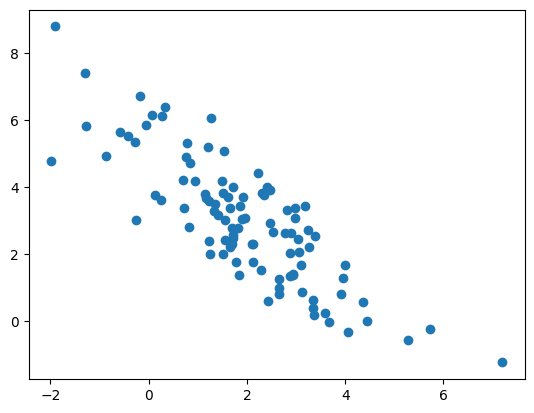

In [99]:
import matplotlib.pyplot as plt

plt.scatter(X[:, 0], X[:, 1])

### Visualize the centered data
Notice that the data visualized above is not centered on the origin (0,0). Use the function defined above to center the data, and the replot it.

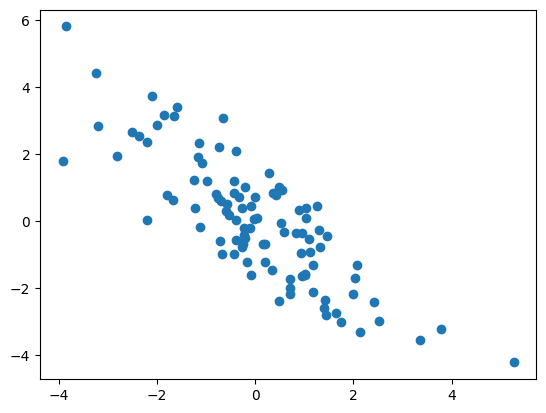

In [100]:
## Your code here
# Center the data
X_centered = center_data(X)
plt.scatter(X_centered[:, 0], X_centered[:, 1])

### Visualize the first eigenvector
Visualize the vector defined by the first eigenvector.
To do this you need:
- Use the *PCA()* function to recover the eigenvectors
- Plot the centered data as done above 
- The first eigenvector is a 2D vector (x0,y0). This defines a vector with origin in (0,0) and head in (x0,y0). Use the function *plot()* from matplotlib to plot a line over the first eigenvector.

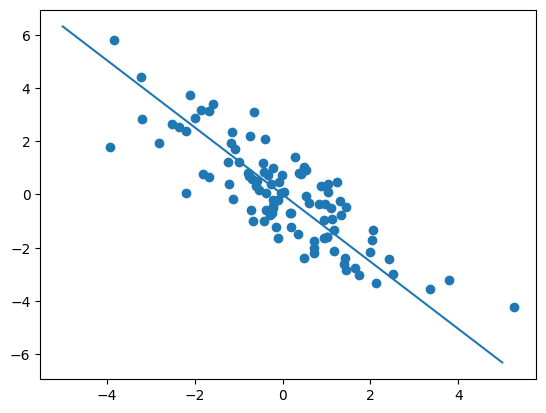

In [101]:
pca_eigvec = pca(X, 2)[0]
first_eigvec = pca_eigvec[:, 0]
plt.scatter(X_centered[:, 0], X_centered[:, 1])

x = np.linspace(-5, 5, 1000)
y = first_eigvec[1]/first_eigvec[0] * x
plt.plot(x, y)

### Visualize the PCA projection
Finally, use the *PCA()* algorithm to project on a single dimension and visualize the result using again the *scatter()* function.

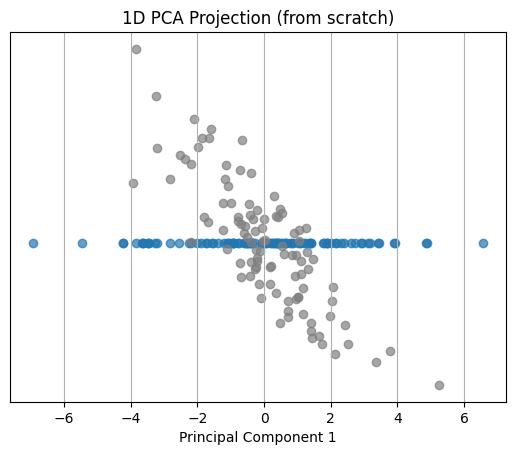

In [102]:
## Your code here
# Run your PCA function for 1D
pca_eigvec_1d, X_pca_1d = pca(X, 1)  # shape: (n_samples, 1)

# Visualize the 1D projection
plt.scatter(X_pca_1d, np.zeros_like(X_pca_1d), alpha=0.7)
plt.scatter(X_centered[:, 0], X_centered[:, 1], alpha=0.7, color='gray')
plt.title("1D PCA Projection (from scratch)")
plt.xlabel("Principal Component 1")
plt.yticks([])  # Hide y-axis ticks
plt.grid(True)
plt.show()


## Part 1.3: Evaluation - When are the results of PCA sensible?
So far we have used PCA on synthetic data. Let us now imagine we are using PCA as a pre-processing step before a classification task. This is a common setup with high-dimensional data. We explore when the use of PCA is sensible.

### Loading the first set of labels
The function *get_synthetic_labeled_data_1()* from the module *data_assignment3* provides a first labeled dataset.

In [103]:
X, y = data_assignment3.get_synthetic_labeled_data_1()

### Running PCA
Process the data using the PCA algorithm and project it in one dimension. Plot the labeled data using *scatter()* before and after running PCA. Comment on the results.

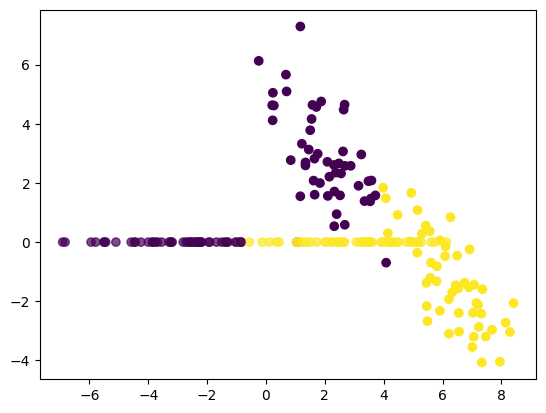

In [104]:
# before PCA
plt.scatter(X[:, 0], X[:, 1], c=y[:, 0])

# after PCA
pca_eigvec_1d, X_pca_1d = pca(X, 1)  # X_pca_1d has shape (N, 1)
plt.scatter(X_pca_1d, np.zeros_like(X_pca_1d), c=y[:, 0], alpha=0.7)

**Comment:** 

Before applying PCA, the data is showed in 2D space, showing some class separation.
After using the first principal component, we reduce dimensionality to 1D. 
We still observe some class separation along this axis, 
meaning PCA managed to retain most of the variance and class structure using just one dimension. 
However, some overlapping between classes may occur due to the loss of information when dropping the second component.      



### Loading the second set of labels
The function *get_synthetic_labeled_data_2()* from the module *data_assignment3* provides a second labeled dataset.

In [105]:
X, y = data_assignment3.get_synthetic_labeled_data_2()

### Running PCA
As before, process the data using the PCA algorithm and project it in one dimension. Plot the labeled data using *scatter()* before and after running PCA. Comment on the results.

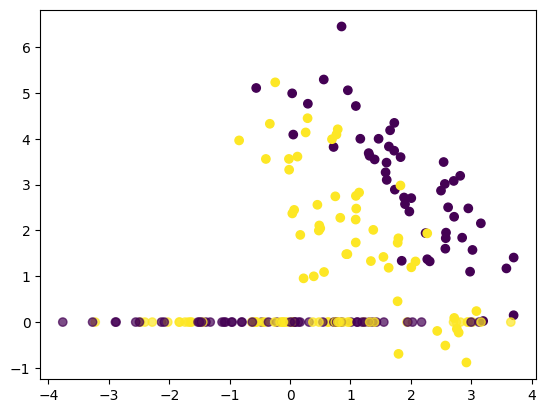

In [106]:
# Your code here
# before PCA
plt.scatter(X[:, 0], X[:, 1], c=y[:, 0])

# after PCA
pca_eigvec_1d, X_pca_1d = pca(X, 1)  # X_pca_1d has shape (N, 1)
plt.scatter(X_pca_1d, np.zeros_like(X_pca_1d), c=y[:, 0], alpha=0.7)

**Comment:** 

In the second run, PCA process the data in a way that leads to significant class overlap. 
This demonstrates that PCA, being unsupervised, doesn't optimize for class separation, 
and its effectiveness heavily depends on the underlying structure of the dataset.

How would the result change if you were to consider only the second eigenvector?
What about if you were to consider both eigenvectors?

**Answer**: 

If we consider only the second eigenvector, the projection will be onto a direction that captures less variance in the data. This means that the resulting 1D projection will class separation may be worse or less clear compared to using the first eigenvector.

If we consider both eigenvectors, we project the data into a 2D space that captures the most variance possible using two directions. This results in much better structure, and the separation between classes becomes more visible, making it more useful.

## Part 1.4: Case study 1 - PCA for visualization

The [*iris* flower dataset](https://en.wikipedia.org/wiki/Iris_flower_data_set) is one of the oldest and best known data collections used for machine learning. It consists of 50 samples from each of three species of iris flowers (*Iris setosa, Iris virginica and Iris versicolor*). Four features were measured from each sample: sepal length, sepal width, petal length and petal width, all in centimeters.

Visualizing a 4-dimensional dataset is impossible; therefore we will use PCA to project our data in 2 dimensions and visualize it.

### Loading the data
The function *get_iris_data()* from the module *data_assignment3* returns the *iris* dataset. It returns a data matrix of dimension [150x4] and a label vector of dimension [150].

In [107]:
X, y = data_assignment3.get_iris_data()

### Visualizing the data by selecting features
Try to visualize the data (using label information) by randomly selecting two out of the four features of the data. You may try different pairs of features.

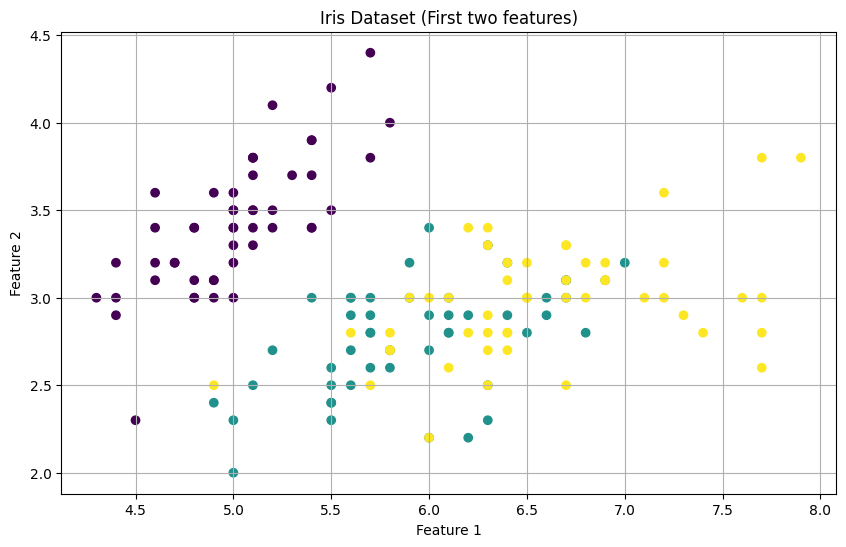

In [108]:
# Your code here
def visualize_iris_data(X, y):
    plt.figure(figsize=(10, 6))
    plt.scatter(X[:, 0], X[:, 1], c=y)
    plt.title("Iris Dataset (First two features)")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.grid(True)
    plt.show()
visualize_iris_data(X, y)

### Visualizing the data by PCA
Process the data using PCA and visualize it (using label information). Compare with the previous visualization and comment on the results.

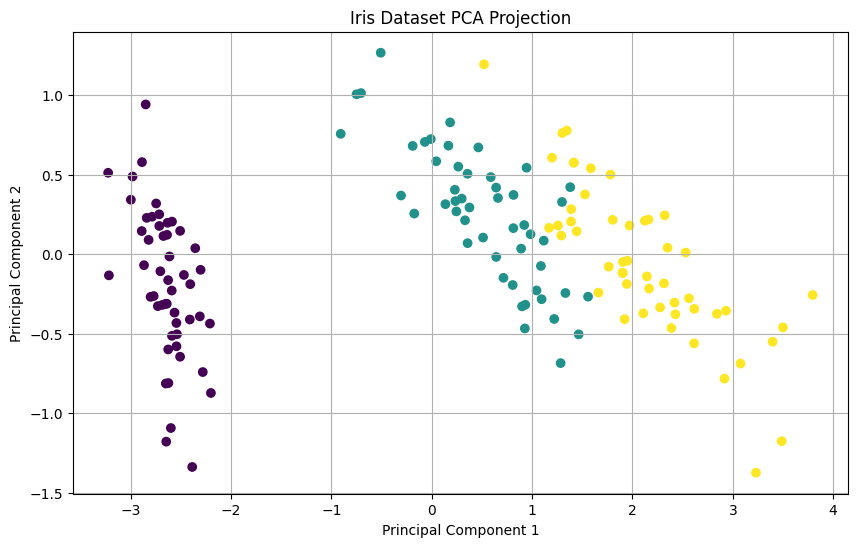

In [109]:
# Your code here
def visualize_iris_pca(X, y):
    pca_eigvec, X_pca = pca(X, 2)
    plt.figure(figsize=(10, 6))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y)
    plt.title("Iris Dataset PCA Projection")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.grid(True)
    plt.show()
visualize_iris_pca(X, y)

**Comment:** 

In first plot (using two original features), one class is easy to see, but the other two are mixed and hard to tell apart.

In second plot (after PCA), the classes are much more clearly separated. This is because PCA uses all four features and finds the best way to show the data in 2D. It helps us see the structure and differences between the classes better than just using two features.



## Part 1.5: Case study 2 - PCA for compression
We now consider the *faces in the wild (lfw)* dataset, a collection of pictures (N=1280) of people. Each pixel in the image is a feature (M=2914).

### Loading the data
The function *get_lfw_data()* from the module *data_assignment3* returns the *lfw* dataset. It returns a data matrix of dimension [1280x2914] and a label vector of dimension [1280]. It also returns two parameters, $h$ and $w$, reporting the height and the width of the images (these parameters are necessary to plot the data samples as images). Beware, it might take some time to download the data. Be patient :) 

In [110]:
X, y, h, w = data_assignment3.get_lfw_data()

### Inspecting the data
Choose one datapoint to visualize (first coordinate of the matrix $X$) and use the function [imshow()](https://matplotlib.org/3.2.1/api/_as_gen/matplotlib.pyplot.imshow.html) to plot and inspect some of the pictures.

Notice that the first argument of *imshow* is the image to be plotted; the image must be provided as a rectangular matrix, therefore we reshape a sample from the matrix $X$ to have height $h$ and width $w$. The parameter *cmap* specifies the color coding; in our case we will visualize the image in black-and-white with different gradations of grey.

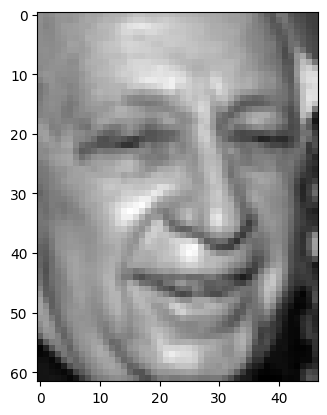

In [111]:
image_number = 4    # display the 4th image of the collection
plt.imshow(X[image_number, :].reshape((h, w)), cmap=plt.cm.gray)

### Implementing a compression-decompression function
Implement a function that first uses PCA to project samples in low-dimensions, and then reconstruct the original image.

*Hint:* Most of the code is the same as the previous PCA() function you implemented.

In [112]:
def encode_decode_pca(A, m):
    # INPUT:
    # A    [NxM] numpy data matrix (N samples, M features)
    # m    integer number denoting the number of learned features (m <= M)
    #
    # OUTPUT:
    # Ahat [NxM] numpy PCA reconstructed data matrix (N samples, M features)
    
    # Center the data
    A_centered = center_data(A)
    
    # Compute the covariance matrix
    C = compute_covariance_matrix(A_centered)
    
    # Compute eigenvalues and eigenvectors
    eigval, eigvec = compute_eigenvalue_eigenvectors(C)
    
    # Sort eigenvalues and eigenvectors
    sorted_eigval, sorted_eigvec = sort_eigenvalue_eigenvectors(eigval, eigvec)
    
    # Select the top m eigenvectors
    pca_eigvec = sorted_eigvec[:, :m]
    
    # Encode: project to lower-dimensional space
    Z = A_centered @ pca_eigvec  # shape (N, m)
    
    # Decode: reconstruct the data in original space
    A_reconstructed = Z @ pca_eigvec.T  # shape (N, M)
    
    # Re-add the original mean to return to uncentered data
    mean_vector = np.mean(A, axis=0)
    Ahat = A_reconstructed + mean_vector

    return Ahat


### Compressing and decompressing the data
Use the implemented function to encode and decode the data by projecting on a lower dimensional space of dimension 200 (m=200).

In [113]:
Xhat = encode_decode_pca(X, m=200)

### Inspecting the reconstructed data
Use the function *imshow* to plot and compare original and reconstructed pictures. Comment on the results.

Text(0.5, 1.0, 'Reconstructed Image')

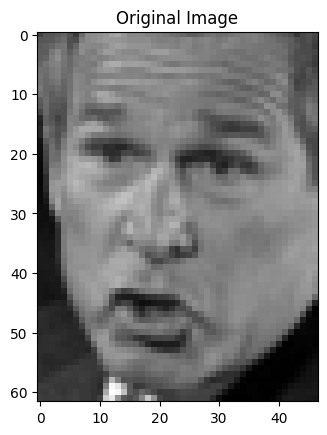

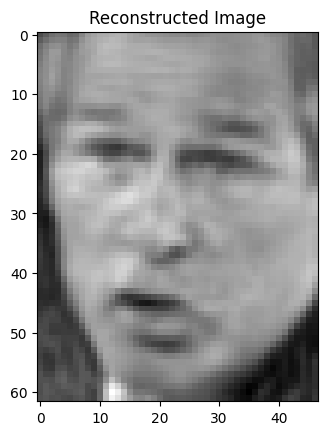

In [114]:
# Your code here
image_number = 6
a = plt.imshow(X[image_number, :].reshape((h, w)), cmap=plt.cm.gray)
plt.title("Original Image")
plt.figure()
b  = plt.imshow(Xhat[image_number, :].reshape((h, w)), cmap=plt.cm.gray)
plt.title("Reconstructed Image")

**Comment:** 

Vi can see that image is compressed and lost some details (easier to see on teeth), it means that my implenetation of encode and decode pca works. 

### Evaluating different compressions
Use the previous setup to generate compressed images using different values of low dimensions in the PCA algorithm (e.g.: 20, 100, 200, 500, 1000). Plot and comment on the results. You can use `plt.subplot(n_rows, n_cols, position)` and `plt.title(titlestring)` to get a nice plot.

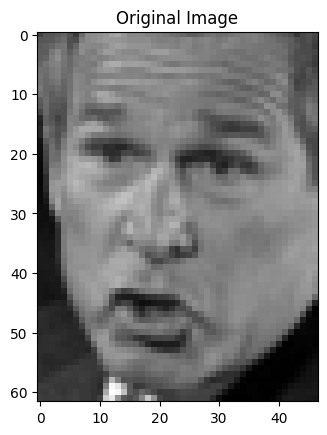

<Figure size 640x480 with 0 Axes>

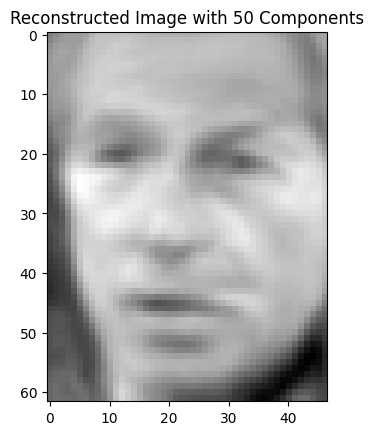

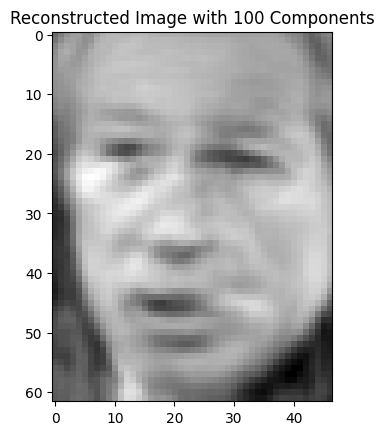

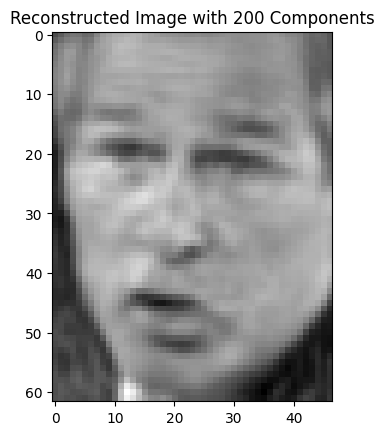

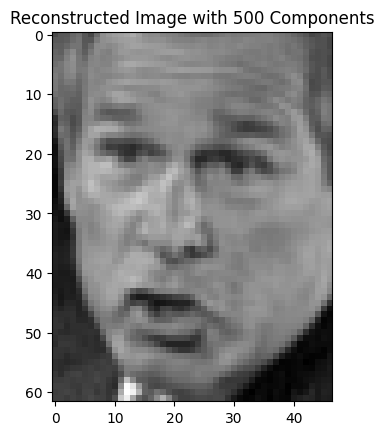

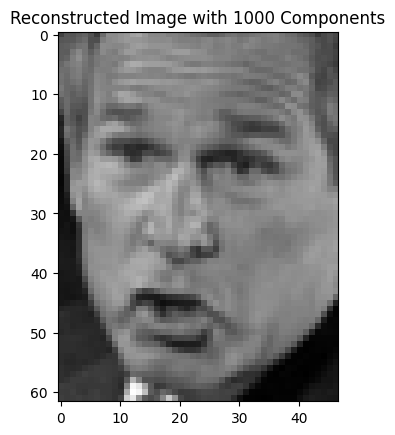

In [115]:
# Your code here
image_number = 6
a = plt.imshow(X[image_number, :].reshape((h, w)), cmap=plt.cm.gray)
plt.title("Original Image")
plt.figure()

compr_list = [50,100,200,500,1000]

for m in compr_list:
    Xhat = encode_decode_pca(X, m)
    plt.figure()
    plt.imshow(Xhat[image_number, :].reshape((h, w)), cmap=plt.cm.gray)
    plt.title(f"Reconstructed Image with {m} Components")

**Comment:** 

We can see that depending on the dimensions we can get more or less compressed images. As more components we than more details image saves in comparrison with original. 

# Part 2: K-Means Clustering
In this section you will use the *k-means clustering* algorithm to perform unsupervised clustering. Then you will perform a qualitative assessment of the results.

## Part 2.1: Applying K-Means and Qualitative Assessment

### Importing scikit-learn library
We start importing the module `sklearn.cluster.KMeans` from the standard machine learning library `scikit-learn`.

In [116]:
from sklearn.cluster import KMeans

### Loading the data
We will use once again the *iris* data set. Start by loading the dataset again.

In [117]:
X, y = data_assignment3.get_iris_data()

### Projecting the data using PCA
To allow for visualization, we project our data in two dimensions as we did previously. This step is not necessary, and we may want to try to use *k-means* later without the PCA pre-processing. But to start, we use PCA, as this will allow for an easy visualization.

In [118]:
# Your code here
pca_eigvec, X_pca = pca(X, 2)

### Running k-means
Use the class *KMeans* to fit and predict the output of the *k-means* algorithm on the projected data (note that we don't use the true labels `y` here). Run the algorithm using the following values of $k=\{2,3,4,5\}$. 

In [119]:
k_values = [2, 3, 4, 5]
y_hats = []

for i in range(len(k_values)):
    # Initialize KMeans object with correct value for k
    # Fit the algorithm to the training data and store the predictions in y_hats

    # Initialize KMeans with current k
    kmeans = KMeans(n_clusters=k_values[i], random_state=42, n_init=10)

    # Fit to PCA-projected data and get cluster assignments
    y_hat = kmeans.fit_predict(X_pca)

    # Store the prediction
    y_hats.append(y_hat)

### Qualitative assessment
Plot the results of running the k-means algorithm, compare with the true labels, and comment.

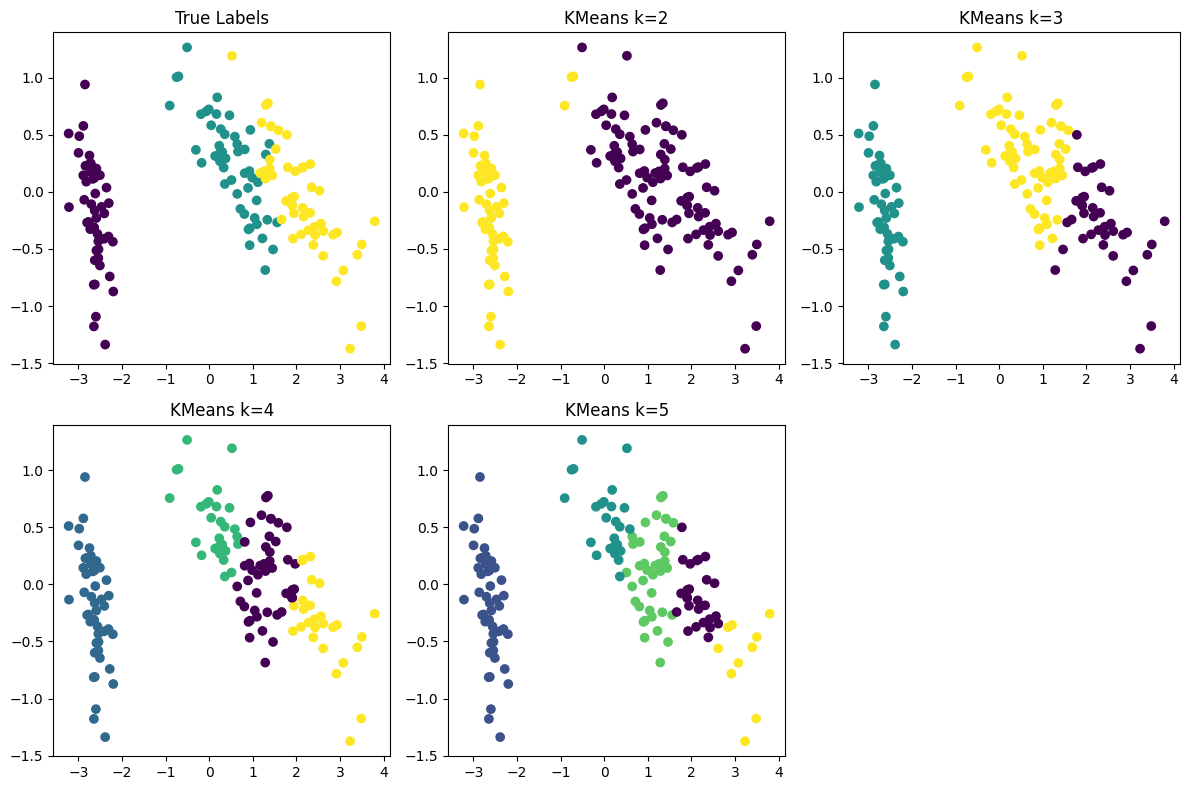

In [120]:
# First plot: true labels
plt.figure(figsize=(12, 8))
plt.subplot(2, 3, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis')
plt.title("True Labels")

# KMeans results
for i in range(len(k_values)):
    plt.subplot(2, 3, i + 2)
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_hats[i], cmap='viridis')
    plt.title(f"KMeans k={k_values[i]}")

plt.tight_layout()
plt.show()


**Comment:** 

K-means works best when k=3, because it matches the three real flower types in the dataset. One group is clearly different, and the other two are mostly correct, but a bit mixed. When k=2, some flowers are wrongly grouped together. When k=4 or k=5, the flowers are split into too many groups. So, k=3 gives the best result.

## Part 2.2: Quantitative Assessment of K-Means

Above, we used k-means for clustering and assessed the results qualitatively by visualizing them. However, we often want to measure in a quantitative way how good a clustering is. To do this, we will use a classification task to **evaluate numerically how good the learned clusters are for all the different values of k you used above (2 to 5)**.

Informally, our evaluation will work as follows: For each of our clusterings ($k=2$ to $k=5$), we will try to learn a mapping from the identified clusters to the correct labels of our datapoints. The reason this can be a sensible evaluation, is that to learn a good mapping, we have to have identified clusters that correspond to the actual classes in our data. We will in other words train 4 different classification models (one for each $k$ value), where the input to our classifier is the cluster each datapoint belongs to, and the target is the correct class for this datapoint. In other words, **we aim to learn to classify datapoints as well as possible with the only information available to the classifier being the cluster that datapoint belongs to**. For some values of k, we will get poorly performing classifiers, indicating that this clustering has not revealed the correct class division in our data.

In practice, you will do the following: Reload the *iris* dataset. Import a standard `LogisticRegression` classifier from the module `sklearn.linear_model`. Use the k-means representations learned previously (`yhats[2],...,yhats[5]`) and the true label to train the classifier. Evaluate your model on the training data (we do not have a test set, so this procedure will assess the model fit instead of generalization) using the `accuracy_score()` function from the `sklearn.metrics` module. Plot a graph showing how the accuracy score varies when changing the value of $k$. Comment on the results.

- Train a Logistic regression model using the first two dimensions of the PCA of the iris data set as input, and the true classes as targets.
- Report the model fit/accuracy on the training set.
- For each value of K:
  - One-Hot-Encode the classes outputed by the K-means algorithm.
  - Train a Logistic regression model on the K-means classes as input vs the real classes as targets.
  - Calculate model fit/accuracy vs. value of K.
- Plot your results in a graph and comment on the K-means fit.

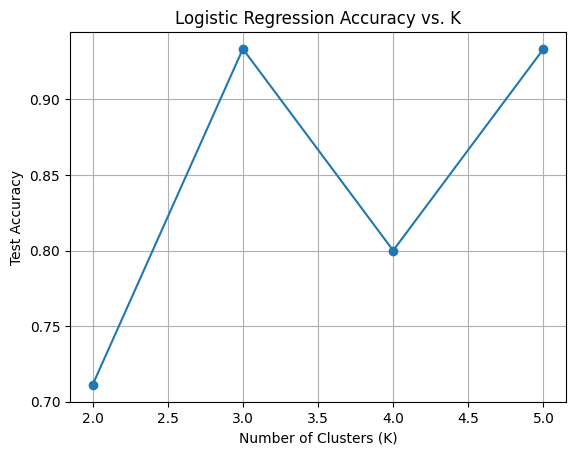

In [121]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

accuracies = []

for i in range(len(k_values)):
    # One-hot encode KMeans cluster labels
    encoder = OneHotEncoder()
    X_encoded = encoder.fit_transform(y_hats[i].reshape(-1, 1))

    # Split into train/test sets (e.g. 70% train, 30% test)
    X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42)

    # Train logistic regression on training data
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, y_train)

    # Predict and evaluate on test set
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

# Plot accuracy vs. k
plt.plot(k_values, accuracies, marker='o')
plt.title("Logistic Regression Accuracy vs. K")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Test Accuracy")
plt.grid(True)
plt.show()


**Comment:** 

The best number of clusters is k=3 because the Iris dataset has 3 real classes. 

k=5 also gives high accuracy, it doesn't mean the clustering is better. 

It just means the model can still learn from extra clusters. 

So k=3 is the most correct and meaningful choice.

# Conclusions 

In this notebook we studied **unsupervised learning** considering two important and representative algorithms: **PCA** and **k-means**.

First, we implemented the PCA algorithm step by step; we then ran the algorithm on synthetic data in order to see its working and evaluated when it makes sense to use it and when it doesn't. We then considered two typical uses of PCA: for **visualization** on the *iris* dataset, and for **compression-decompression** on the *lfw* dataset. We also looked at an additional question that arises when using PCA: the problem of **selection of hyper-parameters**, that is, how to select the optimal hyper-parameter of our algorithm for a particular task.

We then moved to consider the k-means algorithm. In this case we used the implementation provided by *scikit-learn* and applied it to another prototypical unsupervised learning problem: **clustering**. We processed the *iris* dataset with *k-means* and evaluated the results visually. We also considered the problem of **quantitative evaluation** of the results, that is, how to measure the performance or usefulness of k-means clustering on a downstream task (classifying the *iris* samples into their species).